In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,  Dropout,  Dense, Bidirectional
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,21808.101562,23918742607
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,22220.804688,26792596581


In [3]:

data.drop([ 'Close'], axis=1, inplace=True)
# Datetime conversion
data['Date'] = pd.to_datetime(data.index)

# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3075 entries, 2014-09-17 to 2023-02-16
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3075 non-null   float64
 1   High       3075 non-null   float64
 2   Low        3075 non-null   float64
 3   Adj Close  3075 non-null   float64
 4   Volume     3075 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 144.1 KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [4]:
# Keep track of original date values

# Scale the data between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
print(data.shape)

(3075, 5)


In [5]:
# Step 6: Building the Bidirectional LSTM model (cont.)
model = Sequential()
model.add(LSTM(100, input_shape=(1, data.shape[1]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50,activation= 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [6]:
from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each fold and fit/evaluate the model
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = data[train_index], data[test_index]

print('x_test',X_test.shape)
print('y_test',y_test.shape)
print("X_train",X_train.shape)
print('y_train',y_train.shape)





x_test (512, 5)
y_test (512, 5)
X_train (2563, 5)
y_train (2563, 5)


In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
# Reshape the data to a 3D array for use in the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/1000
81/81 [==============================] - 16s 50ms/step - loss: 0.0231 - accuracy: 0.2384 - mean_absolute_error: 0.0851 - val_loss: 0.0074 - val_accuracy: 0.0996 - val_mean_absolute_error: 0.0795
Epoch 2/1000
81/81 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.2544 - mean_absolute_error: 0.0277 - val_loss: 0.0025 - val_accuracy: 0.1191 - val_mean_absolute_error: 0.0450
Epoch 3/1000
81/81 [==============================] - 1s 14ms/step - loss: 0.0017 - accuracy: 0.2696 - mean_absolute_error: 0.0208 - val_loss: 0.0012 - val_accuracy: 0.3125 - val_mean_absolute_error: 0.0288
Epoch 4/1000
81/81 [==============================] - 1s 16ms/step - loss: 0.0017 - accuracy: 0.2485 - mean_absolute_error: 0.0205 - val_loss: 0.0018 - val_accuracy: 0.0996 - val_mean_absolute_error: 0.0312
Epoch 5/1000
81/81 [==============================] - 1s 15ms/step - loss: 0.0014 - accuracy: 0.2415 - mean_absolute_error: 0.0188 - val_loss: 0.0020 - val_accuracy: 0.320

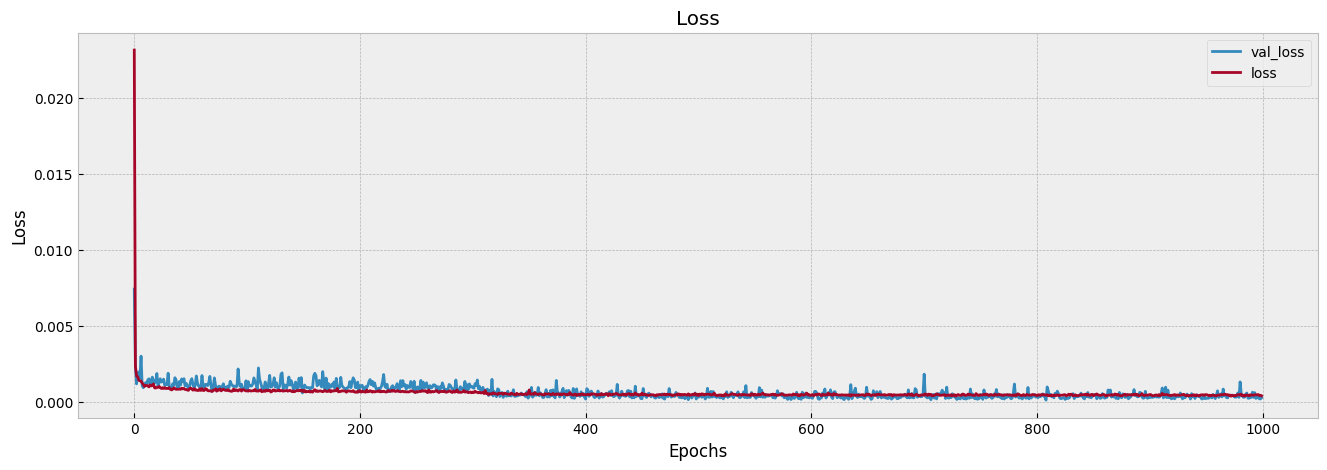

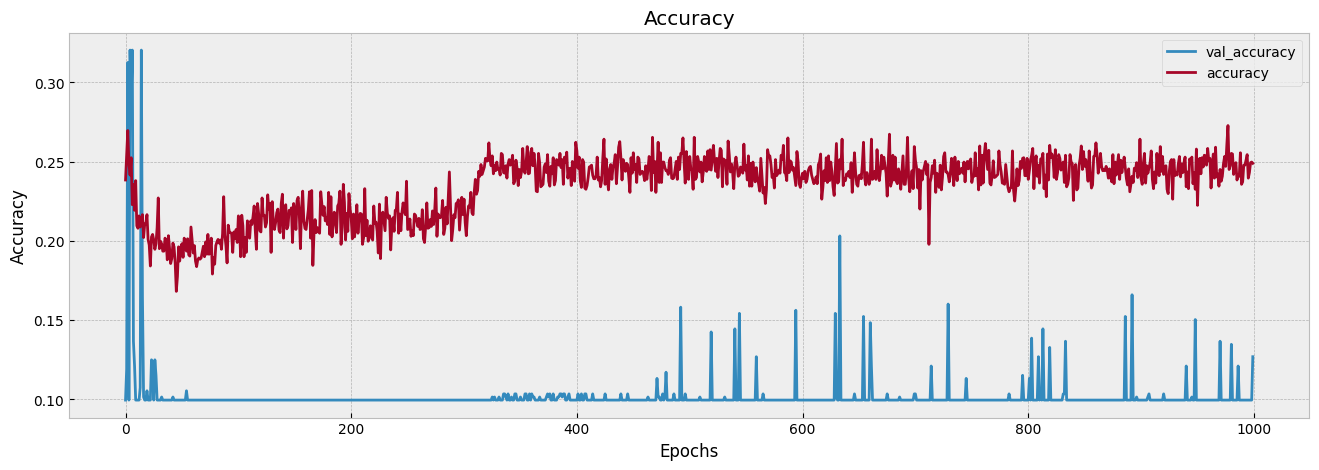

In [10]:
visualize_training_results(history)

In [11]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)


Test loss: [0.0002926272281911224, 0.126953125, 0.011019948869943619]


In [12]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)


y_pred = scaler.inverse_transform(y_pred)

y_test = scaler.inverse_transform(y_test)
y_pred_df = pd.DataFrame(y_pred, columns=["Open", "High", "Low", "Adj Close", "Volume"])
y_test_df = pd.DataFrame(y_test, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test,end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)




16/16 [==============================] - 5s 6ms/step
y_pred (512, 5)
y_test (512, 5)


In [13]:
#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

MAPE: 4.8507%
RMSE: 3546477827.8743
MSE: 12577504983604183040.0000
MAE:914019961.4419


In [14]:
y_pred_df

,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-09-23,44757.457031,45912.109375,43768.722656,45042.566406,3.664165e+10
2021-09-24,44070.058594,45251.269531,42998.949219,44332.789062,4.240607e+10
2021-09-25,43285.769531,44399.500000,42343.589844,43567.335938,3.447830e+10
2021-09-26,43302.261719,44414.242188,42364.519531,43584.800781,3.418751e+10
2021-09-27,43668.648438,44788.792969,42723.988281,43953.003906,3.442549e+10
...,...,...,...,...,...
2023-02-12,22352.835938,22911.572266,21879.359375,22490.037109,1.814643e+10
2023-02-13,22097.652344,22673.017578,21571.962891,22219.576172,2.355101e+10
2023-02-14,22297.861328,22889.410156,21741.820312,22415.560547,2.619932e+10


In [15]:
y_test_df

,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-09-23,43560.296875,44942.175781,43109.339844,44895.097656,3.424406e+10
2021-09-24,44894.300781,45080.492188,40936.558594,42839.750000,4.283935e+10
2021-09-25,42840.890625,42996.257812,41759.921875,42716.593750,3.160472e+10
2021-09-26,42721.628906,43919.300781,40848.460938,43208.539062,3.066122e+10
2021-09-27,43234.183594,44313.246094,42190.632812,42235.730469,3.098003e+10
...,...,...,...,...,...
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,1.782105e+10
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,2.391874e+10
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,2.679260e+10


In [16]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))

smape: 4.2497%


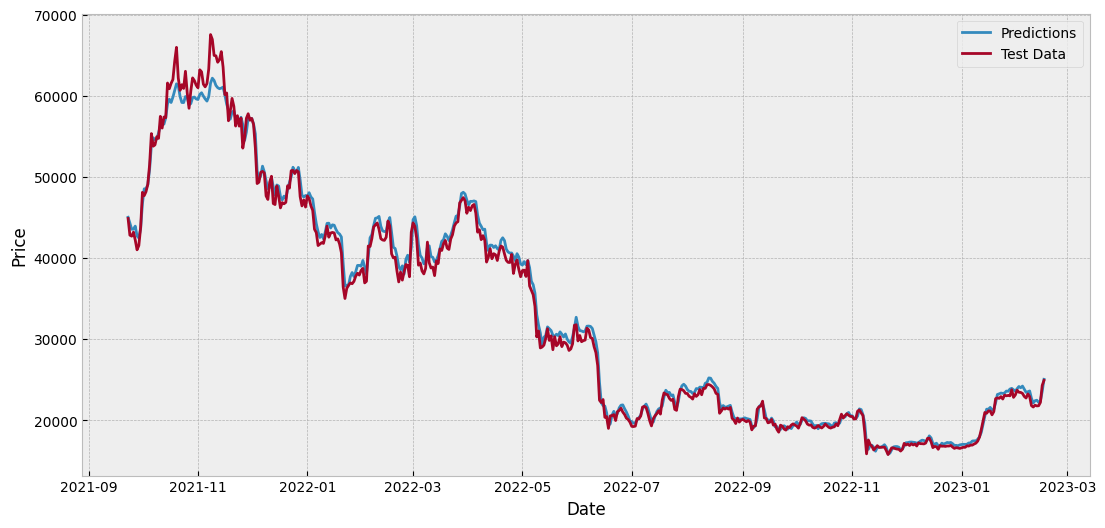

In [17]:
import matplotlib.pyplot as plt

# Assume that you have stored the date information in a variable called 'date'
# Assume that you have stored the predictions in a variable called 'y_pred'
# Assume that you have stored the test data in a variable called 'y_test'

# Plot the test data and predictions on a line chart
plt.figure(figsize=(13,6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Use the trained model to make predictions
future_predictions = model.predict(X_test[-10:, :].reshape(10, 1, X_test.shape[2]))


# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)
# Creating a DF of the predicted prices

future_predictions = pd.DataFrame(future_predictions, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Generate dates for the next 10 days
today = pd.Timestamp.now().date()
prediction_dates = pd.date_range(today, periods=10, freq='D')

# Add back the date values to the DataFrame
future_predictions['Date'] = prediction_dates
future_predictions.set_index('Date', inplace=True)

# Print the predictions
print(future_predictions)



1/1 [==============================] - 3s 3s/step
                    Open          High           Low     Adj Close  \
Date                                                                 
2023-02-16  23403.990234  24024.544922  22827.863281  23532.091797   
2023-02-17  23497.160156  24113.103516  22936.433594  23629.982422   
2023-02-18  22611.406250  23234.726562  21992.318359  22718.972656   
2023-02-19  22040.500000  22626.677734  21485.781250  22155.011719   
2023-02-20  22287.031250  22838.687500  21827.855469  22426.591797   
2023-02-21  22352.835938  22911.572266  21879.359375  22490.037109   
2023-02-22  22097.652344  22673.017578  21571.962891  22219.576172   
2023-02-23  22297.861328  22889.410156  21741.820312  22415.560547   
2023-02-24  23459.042969  24103.505859  22827.445312  23575.355469   
2023-02-25  24955.228516  25672.886719  24215.128906  25067.593750   

                  Volume  
Date                      
2023-02-16  2.663574e+10  
2023-02-17  2.505856e+10  
2

Original values for the next 10 days:
Date
2023-02-16    23532.091797
2023-02-17    23629.982422
2023-02-18    22718.972656
2023-02-19    22155.011719
2023-02-20    22426.591797
2023-02-21    22490.037109
2023-02-22    22219.576172
2023-02-23    22415.560547
2023-02-24    23575.355469
2023-02-25    25067.593750
Name: Adj Close, dtype: float32


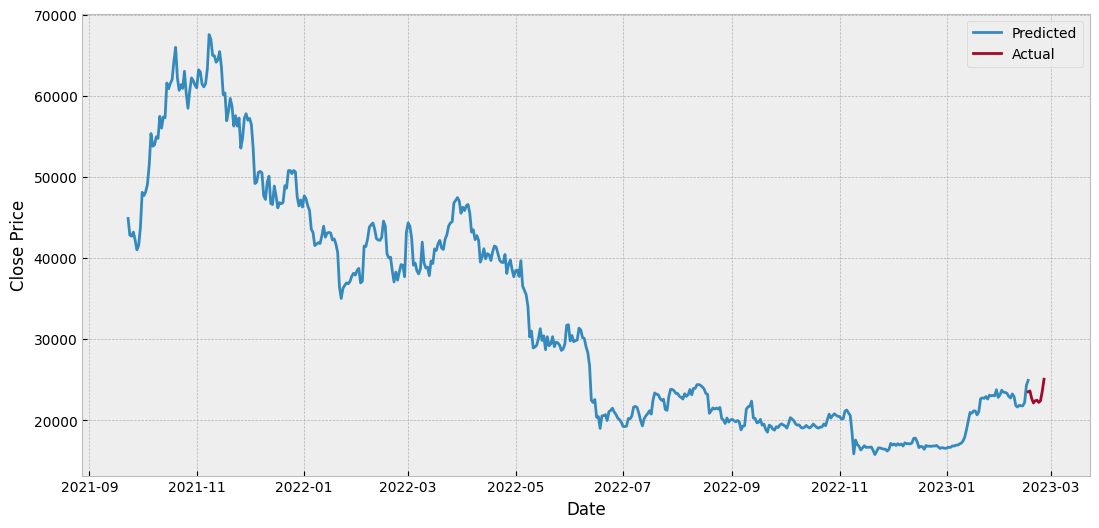

In [19]:
import matplotlib.pyplot as plt



print("Original values for the next 10 days:")
print(future_predictions['Adj Close'])

# Plot the predictions and the true values
plt.figure(figsize=(13,6))
plt.plot(y_test_df['Adj Close'], label='Actual')
plt.plot(future_predictions['Adj Close'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(["Predicted", "Actual"])
plt.show()
